In [75]:
from glob import glob
import json
import requests
from pyproj import Proj

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_style('white')

# Settings

In [2]:
url_openstreetmap = "https://nominatim.openstreetmap.org/search"

In [3]:
dir_geotop = 'local_data/GeoTOP_v01r6s1_csv_bestanden/'

In [4]:
map_lithoclasses = dict({
    0: 'NaN', 1: 'veen', 2: 'klei', 3: 'kleiig_zand', 
    4: 'vervallen', 5: 'zand_fijn', 6: 'zand_matig_grof',
    7: 'zand_grof', 8: 'grind'
    })

In [5]:
material_color_mapping = dict({
    'NaN': '#ffffff',
    'veen': '#64564c',
    'klei':'#b2a38d', 
    'kleiig_zand':'#8a8783', 
    'vervallen':'#ee82ee', 
    'zand_fijn':'#000000', 
    'zand_matig_grof': '#c5c5c5',  
    'zand_grof': '#616160',
    'grind': '#ffff82',
    'schelpen': '#eb611e' 
    })


# Utils

In [36]:
def get_data_for_rd_coordinates(x, y, data):
    df = data.loc[x, y, :].sort_index(ascending=False)
    
    df = df.copy()  # avoid SettingWithCopyWarning
    df['x'] = x
    df['y'] = y
    
    return df.reset_index()
    
def get_material_and_color_profile(datapoint, map_lithoclasses, material_color_mapping):
    datapoint['lithoclass_material'] = [map_lithoclasses[lithoclass] for lithoclass in datapoint.lithoklasse]
    
    datapoint.loc[:, 'color_lithoclass_material'] = [
        material_color_mapping[datapoint.loc[z, 'lithoclass_material']] for z in datapoint.index
        ]

    return datapoint

# User Input

In [6]:
user_input_address = "Depot Boijmans Van Beuningen"

# Get RD coordinates from Address


### get geometric coordinates for address

In [7]:
geo = requests.get(
    url_openstreetmap, 
    headers={"User-Agent": "CaraLogic (contact: silvia@caralogic.com)"}, 
    params={"q": user_input_address, "format": "json", "limit": 1}
    )

geo.raise_for_status()
if len(geo.json()) == 0:
    print(f"no data found for {user_input_address}")
    
location = geo.json()[0]
latitude, longitude = location['lat'], location['lon']
print(f"Coordinates found for {user_input_address}: {latitude}, {longitude} (lat, lon)")

Coordinates found for Depot Boijmans Van Beuningen: 51.9139529, 4.4711320 (lat, lon)


### convert to RD coordinates

In [80]:
rd = Proj('epsg:28992')

x, y = rd(longitude, latitude)
x, y = 91978, 436543
print(f"RD coordinates in meter: x(east)={x}, y(north)={y}")
# !!!ToDO: check projection. Reference says 92345, 436705 or 91973, 436559

RD coordinates in meter: x(east)=91978, y(north)=436543


# Import GeoTop data

In [81]:
ls_files = [file for file in glob(dir_geotop + '*.csv')]
ls_files

['local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B09.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B08.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B03.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B02.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B01.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B05.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B04.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B06.csv',
 'local_data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B07.csv']

In [10]:
ls_data = [pd.read_csv(file, index_col=[0,1,2]) for file in ls_files]

data = pd.concat(ls_data).sort_index()
data.head(10)

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   
                 -47.25        5120            6         0.04         0.13   
                 -46.75        5120            6         0.02         0.13   
                 -46.25        5120            2         0.02         0.27   
                 -45.75        5120            5         0.02         0.25   
                 -45.25        5120            6         0.02         0.25   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   
                 -47.25                0.23               0.0   
                 -46.75                0.15               0.0   
                 -46.25                0.21               0.0   
                 -45.75                0.33               0.0   
                 -45.25                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   
                 -47.25              0.22                    0.28   
                 -46.75              0.30                    0.29   
                 -46.25              0.23                    0.18   
                 -45.75              0.19                    0.15   
                 -45.25              0.16                    0.17   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   
                 -47.25              0.10           0.0              0.0   
                 -46.75              0.11           0.0              0.0   
                 -46.25              0.09           0.0              0.0   
                 -45.75              0.06           0.0              0.0   
                 -45.25              0.07           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   
                 -47.25                          0.92   
                 -46.75                          0.89   
                 -46.25                          0.9

# Find data points in dataset

## find closest point in dataset

!!! ToDo: get points left and right not the 2 second closet... 9er raster with center point

In [11]:
x_target, y_target = x, y

xy = np.array(data.index.droplevel('z').unique().tolist()) 
distances = np.sqrt((xy[:, 0] - x_target)**2 + (xy[:, 1] - y_target)**2)
sorted_indices = np.argsort(distances)

closest_xy = xy[sorted_indices[0]]

second_closest_xy = xy[sorted_indices[1]]
third_closest_xy = xy[sorted_indices[2]]

print("Closest:", closest_xy)
print("Second closest:", second_closest_xy)
print("Third closest:", third_closest_xy)

datapoints_closest = [closest_xy, second_closest_xy, third_closest_xy]

Closest: [ 91950. 436450.]
Second closest: [ 91950. 436550.]
Third closest: [ 91850. 436450.]


## Get box around address 

In [82]:
x_target, y_target = x, y

xy = np.array(data.index.droplevel('z').unique().tolist())

distances = np.sqrt((xy[:, 0] - x_target)**2 + (xy[:, 1] - y_target)**2)
sorted_indices = np.argsort(distances)
closest_xy = xy[sorted_indices[0]]
print("Closest:", closest_xy)

dx = dy = 100
x_min, x_max = closest_xy[0] - dx, closest_xy[0] + dx
y_min, y_max = closest_xy[1] - dy, closest_xy[1] + dy

mask = (xy[:, 0] >= x_min) & (xy[:, 0] <= x_max) & (xy[:, 1] >= y_min) & (xy[:, 1] <= y_max)
points_in_box = xy[mask]

print("Points within box:", points_in_box)

Closest: [ 91950. 436550.]
Points within box: [[ 91850. 436450.]
 [ 91850. 436550.]
 [ 91850. 436650.]
 [ 91950. 436450.]
 [ 91950. 436550.]
 [ 91950. 436650.]
 [ 92050. 436450.]
 [ 92050. 436550.]
 [ 92050. 436650.]]


kans = chance = likelihood

'lithostrat', 'lithoklasse', 
'kans_1_veen', 'kans_2_klei','kans_3_kleiig_zand', 'kans_4_vervallen', 'kans_5_zand_fijn',
'kans_6_zand_matig_grof', 'kans_7_zand_grof', 'kans_8_grind', 'kans_9_schelpen', 
'modelonzekerheid_lithoklasse', 'modelonzekerheid_lithostrat'

In [83]:
datapoints = [get_data_for_rd_coordinates(rd_closest[0], rd_closest[1], data) for rd_closest in points_in_box]

In [84]:
profiles = [
    get_material_and_color_profile(datapoint, map_lithoclasses, material_color_mapping) for datapoint in datapoints
    ]

In [85]:
profile_per_datapoint = [
    profile[['x', 'y', 'z', 'lithoclass_material', 'color_lithoclass_material']].set_index('z') 
    for profile in profiles
    ]

# Data Vis 3D Projection

In [86]:
save = True

save figure


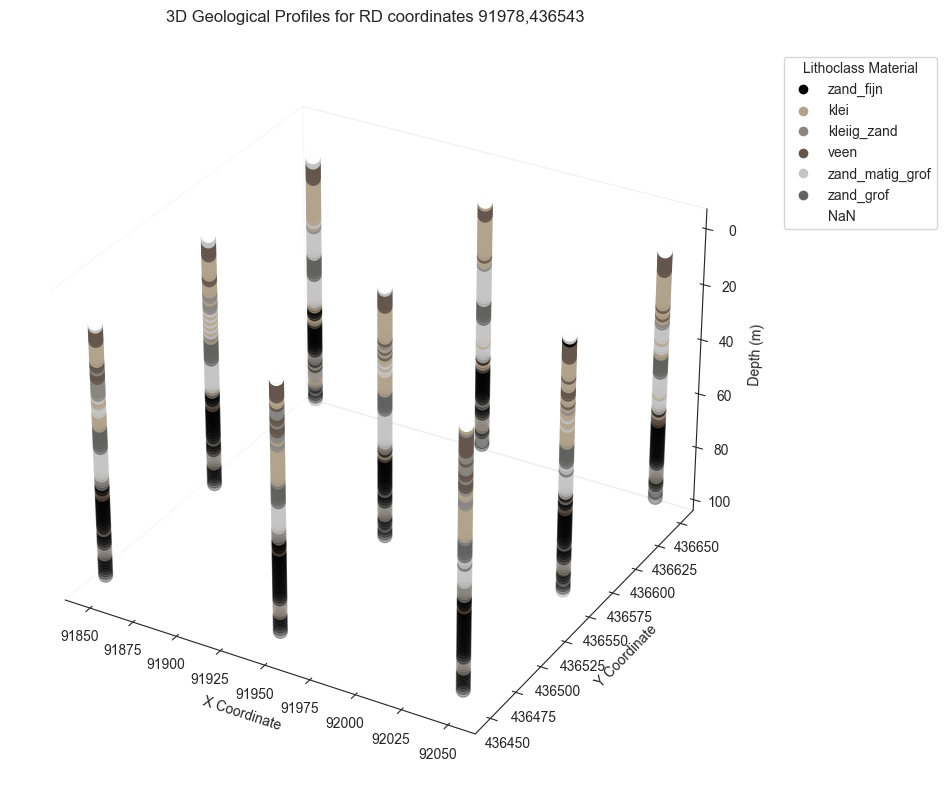

In [89]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

material_colors = {}

for profile in profiles:
    df = profile[['x', 'y', 'lithoclass_material', 'color_lithoclass_material']].sort_index(ascending=False)
    
    xs = df['x'].values
    ys = df['y'].values
    zs = df.index.values    
    cs = df['color_lithoclass_material'].values
    
    ax.scatter(xs, ys, zs, c=cs, s=100, depthshade=True)
    
    # Register materials for legend
    for mat, col in zip(df['lithoclass_material'], df['color_lithoclass_material']):
        material_colors[mat] = col

# Axes labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Depth (m)")

# Invert Z-axis to have shallowest depth at top
ax.set_zlim(ax.get_zlim()[::-1])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=mat, markerfacecolor=color, markersize=8)
    for mat, color in material_colors.items()
    ]
ax.legend(handles=handles, title="Lithoclass Material", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"3D Geological Profiles for RD coordinates {int(x)},{int(y)}", pad=20)
plt.tight_layout()
if save:
    print('save figure')
    fig.savefig(
    f"3D_geological_profiles_box_for_{int(x)}_{int(y)}.png",
    dpi=600,               # high resolution
    bbox_inches="tight",   # trim extra white space
    transparent=True       # makes background transparent
    )
plt.show()


# Output as JSON

In [88]:
selected_columns = ['x', 'y', 'z', 'lithoklasse', 'lithoclass_material', 'color_lithoclass_material']

profiles_json = [df[selected_columns].to_dict(orient='records') for df in profiles]

name_file = f"boxed_depth_profile_for_{int(x)}_{int(y)}.json"
with open(name_file, 'w') as f:
    json.dump(profiles_json, f, indent=4)

print(name_file)

boxed_depth_profile_for_91978_436543.json


# PyVista - city top view 3D

In [166]:
import pyvista as pv

In [167]:
xmin,ymin,xmax,ymax = 91878,436443,92078,436643

In [134]:
response = requests.get(f"https://api.3dbag.nl/collections/pand/items?bbox={xmin},{ymin},{xmax},{ymax}&limit=100&offset=1")

In [168]:
data_city = response.json()

In [169]:
vertices = data_city['features'][0]['vertices']

In [170]:
def extract_faces(boundary):
    """
    Recursively flatten CityJSON boundary arrays into a list of faces.
    Each face is a list of vertex indices.
    """
    faces = []
    if isinstance(boundary, list):
        if all(isinstance(x, int) for x in boundary):
            faces.append(boundary)
        else:
            for b in boundary:
                faces.extend(extract_faces(b))
    return faces

boundaries = []
city_objects = data_city['features'][0]['CityObjects']
for obj in city_objects.values():
    for geom in obj['geometry']:
        boundaries.extend(extract_faces(geom['boundaries']))


In [171]:
pv_faces = []
for f in boundaries:
    pv_faces.append(len(f))
    pv_faces.extend(f)


In [172]:
mesh = pv.PolyData(vertices, pv_faces)
mesh.compute_normals(inplace=True)

/Users/silviazieger/Coding/Python/UnderwaterVisuals_Rotterdam/.venv/lib/python3.12/site-packages/pyvista/core/utilities/points.py:79: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


PolyData (0x116b69cc0)
  N Cells:    1384
  N Points:   2246
  N Strips:   0
  X Bounds:   0.000e+00, 1.754e+05
  Y Bounds:   0.000e+00, 2.265e+05
  Z Bounds:   1.873e+03, 3.402e+04
  N Arrays:   2

In [178]:
pv.set_jupyter_backend("html")

plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightblue", show_edges=True)
plotter.add_axes()
plotter.show()

usage: ipykernel_launcher.py [-h] [--server] [--banner] [--app] [--no-http]
                             [--authKeyFile AUTHKEYFILE] [--hot-reload]
                             [--trame-args TRAME_ARGS] [--follow-symlinks]
                             [--debug] [--nosignalhandlers] [--host HOST]
                             [-p PORT] [--timeout TIMEOUT] [--content CONTENT]
                             [--authKey AUTHKEY] [--ws-endpoint WS]
                             [--no-ws-endpoint] [--fs-endpoints FSENDPOINTS]
                             [--reverse-url REVERSE_URL] [--ssl SSL]
ipykernel_launcher.py: error: ambiguous option: --f=/Users/silviazieger/Library/Jupyter/runtime/kernel-v300da5028454f8e3ecba3f8851d80fadc796d5306.json could match --follow-symlinks, --fs-endpoints


SystemExit: 2

/Users/silviazieger/Coding/Python/UnderwaterVisuals_Rotterdam/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
